In [1]:
%load_ext autoreload
import sys
sys.path.append("../../..")

import numpy as np
import pickle
import csv
import config
from scipy.integrate import odeint
from copy import deepcopy

import main as main
import darkhistory.physics as phys
from darkhistory.physics import ymu_distortion
from darkhistory.spec.spectrum import Spectrum
from plotting_utils import plot_distortion

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

direc = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'
xnorm = 1 / phys.hbar / 2 / np.pi / 1e9
ynorm = phys.nB * phys.hbar * 2 * np.pi * phys.c * 1e4 * phys.ele / 4 / np.pi

# Trough and peak location of distortions

In [2]:
### Generate data

# result_3e6 = main.evolve(
#     DM_process='decay', mDM=3e6, lifetime=1e25,
#     primary='elec_delta',
#     start_rs = 10,
#     coarsen_factor=12, backreaction=False, distort=True,
#     struct_boost=struct_boost,
#     end_rs=5
# )
# pickle.dump(result_3e6, open(direc+'distortion_test_elec_decay_m3e6_z10.p','wb'))

# result_3e7 = main.evolve(
#     DM_process='decay', mDM=3e7, lifetime=1e25,
#     primary='elec_delta',
#     start_rs = 10,
#     coarsen_factor=12, backreaction=False, distort=True,
#     struct_boost=struct_boost,
#     end_rs=5
# )
# pickle.dump(result_3e7, open(direc+'distortion_test_elec_decay_m3e7_z10.p','wb'))

In [3]:
### Load data
result_3e6 = pickle.load(open(direc+'distortion_test_elec_decay_m3e6_z10.p','rb'))
result_3e7 = pickle.load(open(direc+'distortion_test_elec_decay_m3e7_z10.p','rb'))

CMB_spec = {'distortion' : Spectrum(result_3e6['distortion'].eng, 
                                    phys.CMB_spec(result_3e6['distortion'].eng, phys.TCMB(1))/phys.nB)}

In [4]:
### Determine Lorentz gamma for the electron decay products
gammas = np.array([3e6, 3e7]) / 2 / 5.11e+5

# Average trough energy
neg_inds_3e6, = np.where(result_3e6['distortion'].N < 0)
neg_inds_3e7, = np.where(result_3e7['distortion'].N < 0)

trough_engs = np.array([
    sum(result_3e6['distortion'].eng[neg_inds_3e6] * result_3e6['distortion'].N[neg_inds_3e6]) / sum(result_3e6['distortion'].N[neg_inds_3e6]),
    sum(result_3e7['distortion'].eng[neg_inds_3e7] * result_3e7['distortion'].N[neg_inds_3e7]) / sum(result_3e7['distortion'].N[neg_inds_3e7])
])

# Average peak energy
peak_engs = 4/3 * gammas**2 * trough_engs

print('Gamma: ')
print(gammas)
print('Approximate energy of upscattered photons: ')
print(peak_engs)
print('Peak frequency [GHz]')
print(peak_engs / 2 / np.pi / phys.hbar / 1e9)

Gamma: 
[ 2.93542074 29.35420744]
Approximate energy of upscattered photons: 
[0.0057254  0.61030987]
Peak frequency [GHz]
[  1384.39533762 147572.27179213]


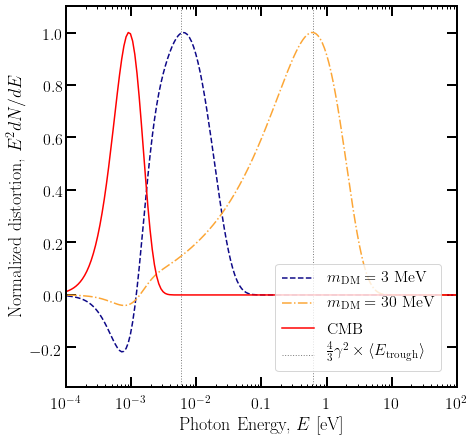

In [6]:
cmap = cm.plasma(np.linspace(0.,0.8,2))

plt.figure(figsize=(7,7))
plt.xscale('log')
plt.axis([1e-4, 1e2, -0.35, 1.1])
plt.plot(result_3e6['distortion'].eng, 
         result_3e6['distortion'].eng**2 * result_3e6['distortion'].dNdE
         / result_3e6['distortion'].eng[53]**2 / result_3e6['distortion'].dNdE[53],
         label=r'$m_\mathrm{DM} = 3$ MeV', color=cmap[0], linestyle='--', linewidth=1.5)
plt.plot(result_3e7['distortion'].eng, 
         result_3e7['distortion'].eng**2 * result_3e7['distortion'].dNdE
         / result_3e7['distortion'].eng[112]**2 / result_3e7['distortion'].dNdE[112],
         label=r'$m_\mathrm{DM} = 30$ MeV', color=cmap[1], linestyle='-.', linewidth=1.5)
plt.plot(result_3e6['distortion'].eng, 
         result_3e6['distortion'].eng**2*phys.CMB_spec(result_3e6['distortion'].eng, phys.TCMB(1))/phys.nB
         / (result_3e6['distortion'].eng[28]**2*phys.CMB_spec(result_3e6['distortion'].eng[28], phys.TCMB(1))/phys.nB),
         label='CMB', color='r', linewidth=1.5)
plt.vlines(peak_engs,-0.35,1.2, 
           label=r'$\frac{4}{3} \gamma^2 \times \langle E_\mathrm{trough} \rangle$', linewidth=1, color='gray', linestyle=':')

plt.xlabel(r'Photon Energy, $E$ [eV]')
plt.ylabel(r'Normalized distortion, $E^2 dN/dE$')
plt.legend(loc='lower right')

plt.savefig(fig_dir+f'spectrum_example1.pdf')
plt.show()

# Comparison to Green's function data from Acharya+Khatri

In [2]:
# First column:  File index
# Second column: redshift
redshifts_1e9 = np.loadtxt(direc+'greens_function/redshift.dat')
redshifts_1e7 = np.loadtxt(direc+'greens_10meve/redshift.dat')

# First column:  Dimensionless frequency x=h\nu/kT_cmb,"nu" is the frequency of the photon
#                Convert to physical frequency via the relation, \nu~56.8*x GHz.
# Second column: Dimensionless intensity (x^3*n), where "n" is the photon occupation number. 
#                The real intensity is given by, I=(2h\nu^3/c^2)*x^3*n, 
#                i.e. multiply by ~2.7*1e-18 W m^-2 Hz^-1 Sr^-1.
greens_fncs = {1e9 : {}, 1e7 : {}}
for index in redshifts_1e9[:,0]:
    greens_fncs[1e9][int(index)] = np.loadtxt(direc+f'greens_function/spectrum_z={index:.0f}.dat')
for index in redshifts_1e7[:,0]:
    greens_fncs[1e7][int(index)] = np.loadtxt(direc+f'greens_10meve/spectrum_z={index:.0f}.dat')

## Load DarkHistory distortions

References: 1304.6120 and 1911.05086

In [4]:
### USEFUL FUNCTIONS

# Only have y-distortions at late redshifts, 
# Green's fnc. = Y_SZ/4 at end of page 2 of 1304.6120
def Gy(eng):
    y_spec = ymu_distortion(eng, 1/4, 1, dist_type='y')
    print(np.max(y_spec.N))
    return y_spec.dNdE * phys.nB * eng * (2*np.pi*phys.hbar) * phys.c / 4 / np.pi

# Distortion given by integrating Green's fnc, Eqn 3 of 1304.6120
# In other words, sum Gy from redshifts of interest, weighted by energy in heating
def y_dist_test(eng, res, mDM, z, cf=12):
    weights = (res['f']['low']['heat'] + res['f']['high']['heat']) * phys.inj_rate('decay', res['rs'], mDM=mDM, lifetime=1e25)
    weights /= phys.CMB_eng_density(phys.TCMB(res['rs']))
    return (
        Gy(eng) # Green's function
        * np.sum(weights * .001 * cf / phys.hubble(res['rs'])) # integrate over redshift
        * 1e4 * phys.ele # units of W / m^2 / ster / Hz
    )

# Energy loss (dE / dlnz) due to Compton scattering
#     for a photon of energy E at redshift rs.
def eng_loss_compton(params):
    E, rs = params
    ne = (phys.nH + phys.nHe)*rs**3
    return ne * phys.thomson_xsec * phys.c * E**2 / phys.hubble(rs) / phys.me

def eng_loss_total(E, lnz):
    rs = np.exp(lnz)
    return eng_loss_compton([E, rs]) + E

# Get distortion from old DH results by summing lowengphot
def get_distortion(lowengphots):
    specs_to_sum = deepcopy(lowengphots)
    specs_to_sum.redshift(np.ones_like(specs_to_sum.rs))
    distortion = Spectrum(specs_to_sum[0].eng, 
                            np.zeros_like(specs_to_sum[0].eng), 
                            rs=1, spec_type='N')
    for i, rs in enumerate(specs_to_sum.rs):
        dist_mask = specs_to_sum[i].eng < phys.rydberg / lowengphots[i].rs
        distortion.N[dist_mask] += specs_to_sum[i].N[dist_mask]
    return distortion

In [5]:
# Load data
inj_zs = [3000, 2985, 2116, 1500]
result_dict = {'m2e9_z3000' : {},
               'm2e7_z2985' : {},
               'm2e7_z2116' : {},
               'm2e7_z1500' : {}}

result_dict['m2e9_z3000']['normal'] = pickle.load(open(direc+'elec_decay_m2e9_z3000-1200_old.p','rb'))
result_dict['m2e9_z3000']['100ion'] = pickle.load(open(direc+'elec_decay_m2e9_z3000-1200_100ion_old.p','rb'))

result_dict['m2e7_z2985']['normal'] = pickle.load(open(direc+'elec_decay_m2e7_inj2985_old.p','rb'))
result_dict['m2e7_z2985']['100ion'] = pickle.load(open(direc+'elec_decay_m2e7_inj2985_100ion_old.p','rb'))

result_dict['m2e7_z2116']['normal'] = pickle.load(open(direc+'elec_decay_m2e7_inj2116_old.p','rb'))
result_dict['m2e7_z2116']['100ion'] = pickle.load(open(direc+'elec_decay_m2e7_inj2116_100ion_old.p','rb'))

result_dict['m2e7_z1500']['normal'] = pickle.load(open(direc+'elec_decay_m2e7_inj1500_old.p','rb'))
result_dict['m2e7_z1500']['100ion'] = pickle.load(open(direc+'elec_decay_m2e7_inj1500_100ion_old.p','rb'))

In [6]:
dist_dict = {'m2e9_z3000' : {},
             'm2e7_z2985' : {},
             'm2e7_z2116' : {},
             'm2e7_z1500' : {}}

for key in result_dict.keys():
    dist_dict[key]['normal'] = get_distortion(result_dict[key]['normal']['lowengphot'])
    dist_dict[key]['100ion'] = get_distortion(result_dict[key]['100ion']['lowengphot'])

In [7]:
# Include heating from compton scattering
y_comp = {}

for key in dist_dict.keys():
    heating_rate = np.zeros_like(result_dict[key]['100ion']['rs'])
    for i in range(1,4):
        lnzs = np.log(result_dict[key]['100ion']['rs'][i:])
        # For each energy in the spectrum, solve for energy of photon
        for j, eng in enumerate(result_dict[key]['100ion']['lowengphot'][i].eng):
            # Calculate heating rate from Compton
            eng_phot = odeint(eng_loss_total, eng, lnzs).flatten() # [eV]
            # Sum over all energies, weighted by N(E)
            heating_rate[i:] += result_dict[key]['100ion']['lowengphot'][i].N[j] * eng_loss_compton([eng_phot, np.exp(lnzs)]) # [eV / lnz / baryon]
    # Normalize to per volume instead of per baryon
    heating_rate *= phys.nB * result_dict[key]['100ion']['rs']**3 # [eV / lnz / cm^3]
    heating_rate /= phys.CMB_eng_density(phys.TCMB(result_dict[key]['100ion']['rs'])) # [1 / lnz]
    print(np.sum(heating_rate * .001 * 12))
    y_comp[key] = Gy(result_dict[key]['100ion']['lowengphot'][0].eng) * np.sum(heating_rate * .001 * 12) * 1e4 * phys.ele # units of W / m^2 / ster / Hz

4.2676196359602737e-17
88874251.41184606


/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.0460748600059496e-15
88874251.41184606
1.573902645818074e-15
88874251.41184606
2.048333541565324e-15
88874251.41184606


## Plot distortions

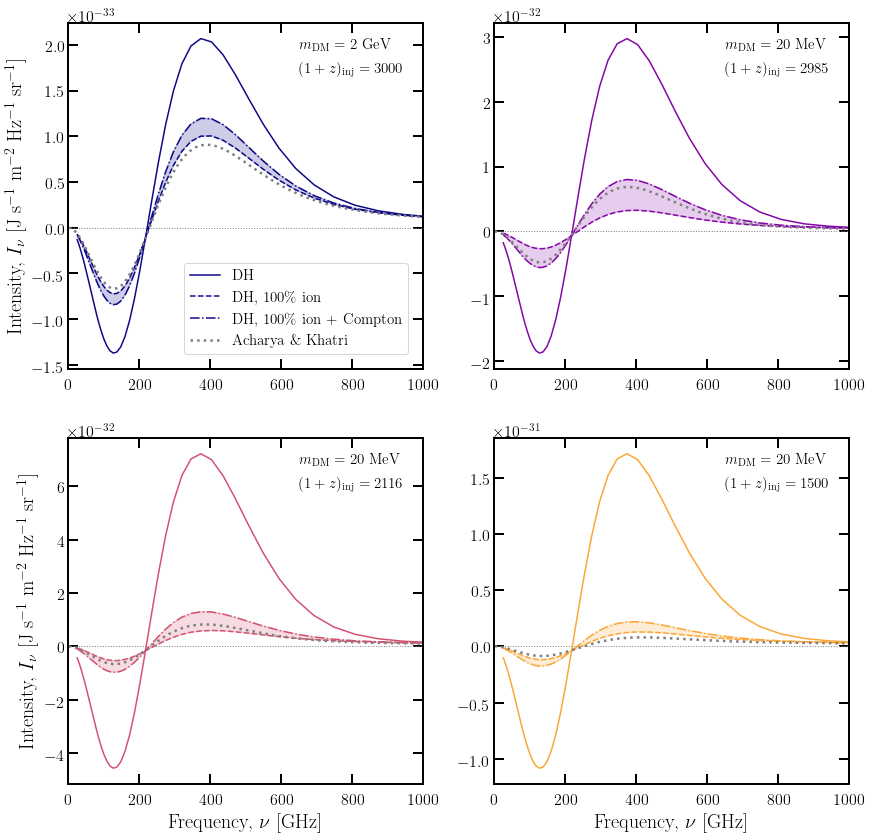

In [7]:
%autoreload
def norm_fac(mDM, rs, cf=12):
    return (
        phys.inj_rate('decay', np.array([rs]), mDM=mDM, lifetime=1e25) 
        * .001 * cf / phys.hubble(rs) / 1e-5 / phys.CMB_eng_density(phys.TCMB(rs))
           )

fig, axarr = plt.subplots(2,2, figsize=(14, 14))
axarr = axarr.flatten()
cmap = cm.plasma(np.linspace(0.,0.8,4))

for i, key in enumerate(dist_dict.keys()):
#     axarr[i].loglog()
    mDM = 2e7
    cf = 12
    if i==0: 
        mDM *=100
        cf = 1
    axarr[i].plot(dist_dict[key]['normal'].eng * xnorm, # GHz
                  (dist_dict[key]['normal'].eng * dist_dict[key]['normal'].dNdE * ynorm) 
                  + y_dist_test(dist_dict[key]['normal'].eng, result_dict[key]['normal'], mDM, inj_zs[i], cf=cf), # W Hz^-1 m^-2 sr^{-1}, 
                  color=cmap[i], linewidth=1.5, label=f"DH")
    axarr[i].plot(dist_dict[key]['100ion'].eng * xnorm, # GHz
                  (dist_dict[key]['100ion'].eng * dist_dict[key]['100ion'].dNdE * ynorm) 
                  + y_dist_test(dist_dict[key]['100ion'].eng, result_dict[key]['100ion'], mDM, inj_zs[i], cf=cf), # W Hz^-1 m^-2 sr^{-1}, 
                  color=cmap[i], linewidth=1.5, linestyle='--', label=f"DH, 100\% ion")
    axarr[i].plot(dist_dict[key]['100ion'].eng * xnorm, # GHz
                  (dist_dict[key]['100ion'].eng * dist_dict[key]['100ion'].dNdE * ynorm) + y_comp[key]
                  + y_dist_test(dist_dict[key]['100ion'].eng, result_dict[key]['100ion'], mDM, inj_zs[i], cf=cf), # W Hz^-1 m^-2 sr^{-1}, 
                  color=cmap[i], linewidth=1.5, linestyle='-.', label=f"DH, 100\% ion + Compton")
    axarr[i].fill_between(dist_dict[key]['100ion'].eng * xnorm, # GHz
                  (dist_dict[key]['100ion'].eng * dist_dict[key]['100ion'].dNdE * ynorm) 
                  + y_dist_test(dist_dict[key]['100ion'].eng, result_dict[key]['100ion'], mDM, inj_zs[i], cf=cf), # W Hz^-1 m^-2 sr^{-1}, 
                  (dist_dict[key]['100ion'].eng * dist_dict[key]['100ion'].dNdE * ynorm) + y_comp[key]
                  + y_dist_test(dist_dict[key]['100ion'].eng, result_dict[key]['100ion'], mDM, inj_zs[i], cf=cf), # W Hz^-1 m^-2 sr^{-1}, 
                  color=cmap[i], linewidth=1.5, alpha=0.2)
    axarr[i].hlines(0, 0, 1500, color='gray', linestyle=':', linewidth=1)
    if i==0:
        axarr[i].text(.65, .92, r'$m_\mathrm{DM} = 2$ GeV', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].text(.65, .85, r'$(1+z)_\mathrm{inj} = 3000$', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].plot(56.8 * greens_fncs[1e9][0][:,0], 
                      2.7 * 1e-18 * greens_fncs[1e9][0][:,1] * norm_fac(2e9, 3000, cf=1), 
                      label="Acharya \& Khatri", color='grey', linestyle=':')
        axarr[i].legend(fontsize=15)
    elif i==1:
        axarr[i].text(.65, .92, r'$m_\mathrm{DM} = 20$ MeV', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].text(.65, .85, r'$(1+z)_\mathrm{inj} = 2985$', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].plot(56.8 * greens_fncs[1e7][4][:,0], 
                      2.7 * 1e-18 * greens_fncs[1e7][4][:,1] * norm_fac(2e7, 2985), 
                      label="Acharya \& Khatri", color='grey', linestyle=':')
    elif i==2:
        axarr[i].text(.65, .92, r'$m_\mathrm{DM} = 20$ MeV', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].text(.65, .85, r'$(1+z)_\mathrm{inj} = 2116$', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].plot(56.8 * greens_fncs[1e7][2][:,0], 
                      2.7 * 1e-18 * greens_fncs[1e7][2][:,1] * norm_fac(2e7, 2116), 
                      label="Acharya \& Khatri", color='grey', linestyle=':')
    elif i==3:
        axarr[i].text(.65, .92, r'$m_\mathrm{DM} = 20$ MeV', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].text(.65, .85, r'$(1+z)_\mathrm{inj} = 1500$', 
                      fontsize=15, transform = axarr[i].transAxes)
        axarr[i].plot(56.8 * greens_fncs[1e7][0][:,0], 
                      2.7 * 1e-18 * greens_fncs[1e7][0][:,1] * norm_fac(2e7, 1500), 
                      label="Acharya \& Khatri", color='grey', linestyle=':')

    axarr[i].set_xlim(0,1000)
    if (i==0) or (i==2):
        axarr[i].set_ylabel(r'Intensity, $I_{\nu}$ '+
                            '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    if (i==2) or (i==3):
        axarr[i].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)

#plt.savefig(fig_dir+'greens_fncs.pdf')
plt.show()